In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import string
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

df_train.name = 'Training set'
df_test.name = 'Test set'
df_all.name = 'All sets'

dfs = [df_train, df_test]


In [3]:
print(df_train.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [4]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'. format(col, df[col].isnull().sum()))

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2
Test set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0


In [5]:
# Dealing with missing values

## Age ##

df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=True).reset_index()
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']


,Feature 1,Feature 2,Correlation Coefficient
7,Age,PassengerId,0.028814
19,Age,Survived,0.077221
23,Age,Parch,0.150917
26,Age,Fare,0.178740
31,Age,SibSp,0.243699
39,Age,Pclass,0.408106
42,Age,Age,1.000000


In [6]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort', ascending=True).reset_index()
df_all_corr.rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Pclass']


,Feature 1,Feature 2,Correlation Coefficient
5,Pclass,Parch,0.018322
13,Pclass,PassengerId,0.038354
16,Pclass,SibSp,0.060832
35,Pclass,Survived,0.338481
38,Pclass,Age,0.408106
40,Pclass,Fare,0.558629
44,Pclass,Pclass,1.000000


In [7]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))

print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Fill missing values in age with the median of sex and pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))


Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [8]:
## Embarked ##

df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [9]:
# After researching, Mrs.Stone embarked from Southampton 'S' with her maid Miss Icard
df_all['Embarked'] = df_all['Embarked'].fillna('S')


In [10]:
## Fare ##

df_all[df_all['Fare'].isnull()]


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [11]:
# Fare is related to family size ('Parch' and 'SibSp') and 'Pclass' features
median_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Therefore, the median 'Fare' value of a male with a third class ticket and no family is a logical choice to fill the missing value.
df_all['Fare'] = df_all['Fare'].fillna(median_fare)

In [12]:
## Cabin ##
# The cabin feature has many missing values and it cannot be simply ignored because some cabins might have higher survival rates.

# The deck column contains the first letter of the cabin column. 'M' stands for missing value.
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# The first letter of the cabin values are the decks in which they are located
df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(
    columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']
).rename(columns={'Name': 'Count'}).transpose()

In [13]:
df_all_decks


Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [18]:
def get_pclass_dist(df):
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M':{}, 'T': {}}

    decks = df.columns.levels[0]
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0

    df_decks = pd.DataFrame(deck_counts)

    # Created a dictionary for every passenger class count in every deck
    deck_percentages = {}

    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]

    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.7

    pclass_1 = df_percentages[0]
    pclass_2 = df_percentages[1]
    pclass_3 = df_percentages[2]

    plt.figure(figsize=(30, 15))
    plt.bar(bar_count, pclass_1, color='#87fbb9', edgecolor='black', width=bar_width, label='Passenger class 1')
    plt.bar(bar_count, pclass_2, color='#87c9fb', edgecolor='black', width=bar_width, label='Passenger class 2')
    plt.bar(bar_count, pclass_3, color='#f37200', edgecolor='black', width=bar_width, label='Passenger class 3')

    plt.xlabel('Deck', size=20, labelpad=30)
    plt.ylabel('Passenger class percentage', size=20, labelpad=30)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 20})
    plt.title('Passenger class distribution in decks', size=24, y=1)

    plt.show()

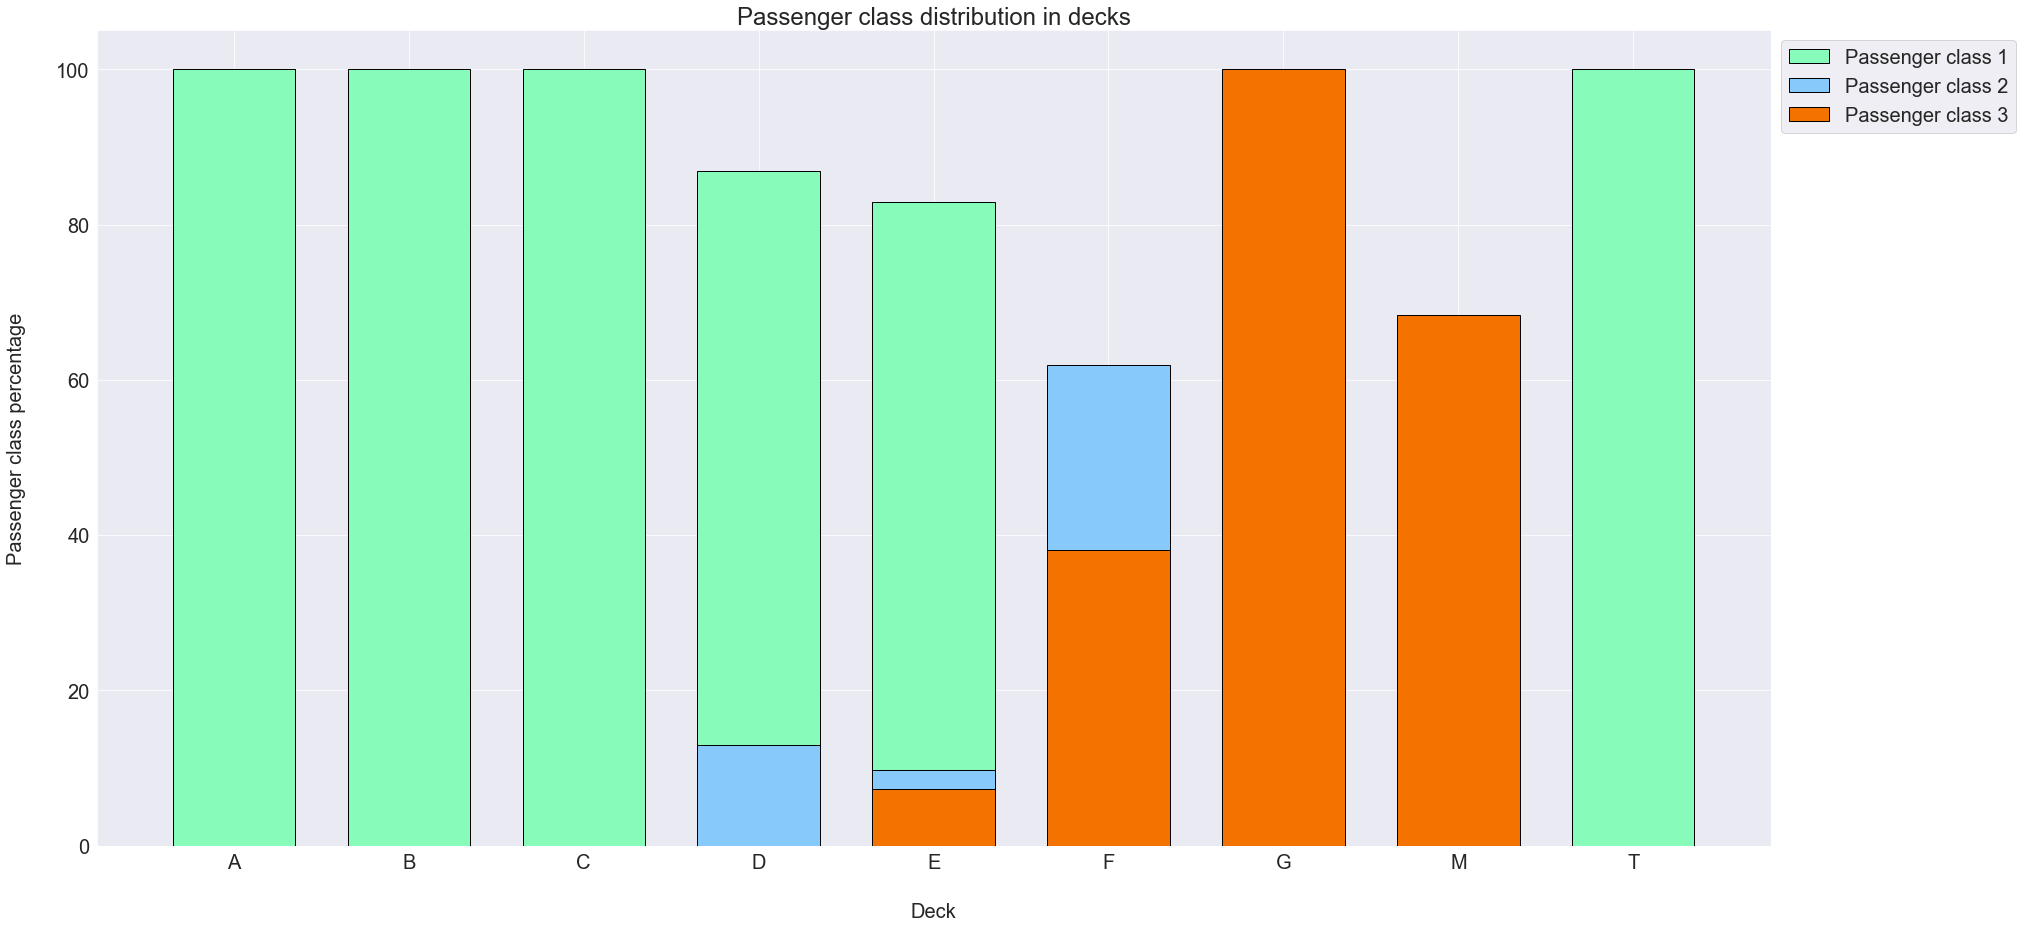

In [19]:
all_deck_count, all_deck_perc = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_perc)


In [21]:
all_deck_perc

{'A': [100.0, 0.0, 0.0],
 'B': [100.0, 0.0, 0.0],
 'C': [100.0, 0.0, 0.0],
 'D': [86.95652173913044, 13.043478260869565, 0.0],
 'E': [82.92682926829268, 9.75609756097561, 7.317073170731707],
 'F': [0.0, 61.904761904761905, 38.095238095238095],
 'G': [0.0, 0.0, 100.0],
 'M': [6.607495069033531, 25.04930966469428, 68.34319526627219],
 'T': [100.0, 0.0, 0.0]}

In [20]:
# Deck T has the closest resemblance to deck A, so that passenger will be regrouped with deck A
dect_regroup = df_all[df_all['Deck'] == 'T'].index
df_all.loc[dect_regroup, 'Deck'] = 'A'


In [22]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(
    columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']
).rename(columns={'Name': 'Count'}).transpose()

df_all_decks_survived


Deck       A       B       C       D       E       F       G        M     
Survived 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0  0.0  1.0
Count      9   7  12  35  24  35   8  25   8  24   5   8   2   2  481  206

In [24]:
def get_survived_dist(df):
    surv_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M':{}, 'T': {}}

    decks = df.columns.levels[0]
    for deck in decks:
        for survive in range(0, 2):
                surv_counts[deck][survive] = df[deck][survive][0]

    df_surv = pd.DataFrame(surv_counts)

    # Created a dictionary for every passenger class count in every deck
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]

    return surv_counts, surv_percentages

def display_survived_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.7

    not_survived = df_percentages[0]
    survived = df_percentages[1]

    plt.figure(figsize=(30, 15))
    plt.bar(bar_count, not_survived, color='#aa99aa', edgecolor='black', width=bar_width, label='Not survived')
    plt.bar(bar_count, survived, color='#33cc33', edgecolor='black', width=bar_width, label='Survived')

    plt.xlabel('Deck', size=20, labelpad=30)
    plt.ylabel('Survival percentage', size=20, labelpad=30)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 20})
    plt.title('Survival percentage in decks', size=24, y=1)

    plt.show()

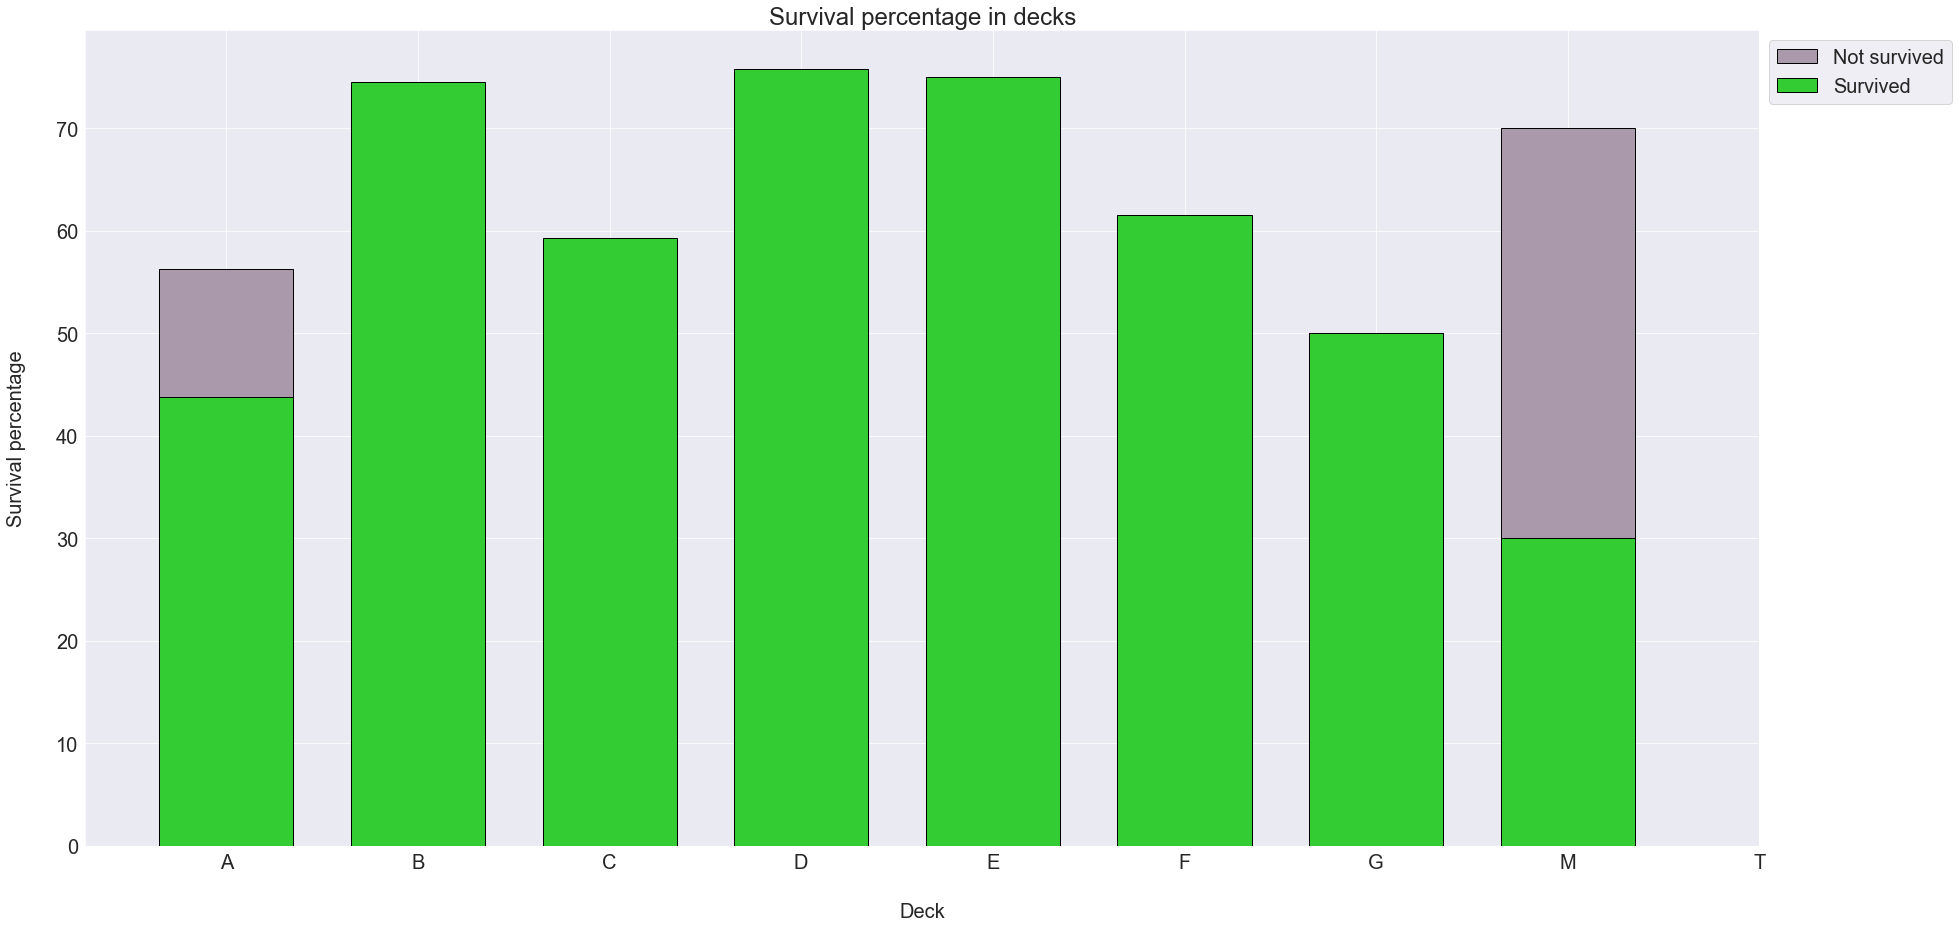

In [26]:
all_surv_counts, all_surv_perc = get_survived_dist(df_all_decks_survived)
display_survived_dist(all_surv_perc)


In [27]:
all_surv_perc


{'A': [56.25, 43.75],
 'B': [25.53191489361702, 74.46808510638297],
 'C': [40.67796610169492, 59.32203389830508],
 'D': [24.242424242424242, 75.75757575757575],
 'E': [25.0, 75.0],
 'F': [38.46153846153847, 61.53846153846154],
 'G': [50.0, 50.0],
 'M': [70.01455604075691, 29.985443959243085],
 'T': [nan, nan]}

In [28]:
# Regroup decks A, B, C as ABC, since all of them have only 1st class passengers
# Regroup decks D, E as DE, since both of them have similar passenger distribution and same survival rate
# Regroup decks F, G as FG, since both of them have similar passenger distribution and same survival rate
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()


M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [29]:
df_all.drop(['Cabin'], inplace=True, axis=1)

def divide_df(all_data):
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0
Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0
